In [11]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [12]:
import sys
sys.executable

'/data/work/home/lksiezak/my_env/bin/python3'

In [19]:
# https://drive.google.com/open?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV
gdd.download_file_from_google_drive(file_id="1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV", 
                                   dest_path="./survey.zip",
                                   unzip=True)

Unzipping...Done.


In [23]:
!ls

brca.txt      __MACOSX	       so_survey_2019.pdf	  survey.zip
data	      my_env	       survey_results_public.csv  Untitled.ipynb
ds_lab.ipynb  README_2019.txt  survey_results_schema.csv


In [24]:
cat survey_results_schema.csv

Column,QuestionText
Respondent,Randomized respondent ID number (not in order of survey response time)
MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
Hobbyist,Do you code as a hobby?
OpenSourcer,How often do you contribute to open source?
OpenSource,How do you feel about the quality of open source software (OSS)?
Employment,Which of the following best describes your current employment status?
Country,In which country do you currently reside?
Student,"Are you currently enrolled in a formal, degree-granting college or university program?"
EdLevel,Which of the following best describes the highest level of formal education that you’ve completed?
UndergradMajor,What was your main or most important field of study?
EduOther,Which of the following types of non-degree education have you used or participated in? Please select all that apply.
OrgSize,Approximately how many people are employed by the company or organ

In [25]:
!wc -l survey_results_schema.csv

86 survey_results_schema.csv


In [29]:
!hdfs dfs -mkdir -p hdfs:///user/${USER}/survey/data

In [33]:
!hdfs dfs -put -f survey_results_public.csv hdfs:///user/${USER}/survey/data

In [34]:
!hdfs dfs -ls hdfs:///user/${USER}/survey/data

Found 2 items
-rw-r--r--   2 lksiezak bdg-ds-stud  196592730 2020-01-25 14:03 hdfs:///user/lksiezak/survey/data/survey_results_public.csv
-rw-r--r--   2 lksiezak bdg-ds-stud       9857 2020-01-25 14:01 hdfs:///user/lksiezak/survey/data/survey_results_schema.csv


In [41]:
import os 
user_name = os.environ.get('USER')
import random
port_name = random.randint(4000, 4999)
port_name

4915

In [45]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.master('yarn-client') \
.config('spark.driver.memory', '1g') \
.config('spark.executor.memory', '1g') \
.config('spark.ui.port', port_name) \
.appName(f'survey_{user_name}') \
.getOrCreate()

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
path = f"/user/{user_name}/survey/data/survey_results_public.csv"
table_name = "survey"

In [47]:
spark.sql(f"USE {user_name}")

DataFrame[]

In [48]:
spark.sql(f"CREATE TABLE IF NOT EXISTS {table_name} \
            using CSV \
            OPTIONS (HEADER=TRUE, INFERSCHEMA TRUE, NULLVALUE 'NA') \
            LOCATION '{path}'")

DataFrame[]

In [49]:
spark.sql(f"DESCRIBE {table_name}").show(100, truncate=False)

+----------------------+-------------+-------+
|col_name              |data_type    |comment|
+----------------------+-------------+-------+
|Respondent            |int          |null   |
|MainBranch            |string       |null   |
|Hobbyist              |string       |null   |
|OpenSourcer           |string       |null   |
|OpenSource            |string       |null   |
|Employment            |string       |null   |
|Country               |string       |null   |
|Student               |string       |null   |
|EdLevel               |string       |null   |
|UndergradMajor        |string       |null   |
|EduOther              |string       |null   |
|OrgSize               |string       |null   |
|DevType               |string       |null   |
|YearsCode             |string       |null   |
|Age1stCode            |string       |null   |
|YearsCodePro          |string       |null   |
|CareerSat             |string       |null   |
|JobSat                |string       |null   |
|MgrIdiot    

In [166]:
pd.set_option("display.max_columns", False) # wyswietl wszystkie kolumny

In [167]:
spark.sql(f"select * from {table_name} limit 10").toPandas()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,None,"Taught yourself a new language, framework, or ...",None,None,4,10,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,NaN,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,None,None,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,None,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,None,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",None,Taken an online course in programming or softw...,None,"Developer, desktop or enterprise applications;...",None,17,None,None,None,None,None,None,I am actively looking for a job,I've never had a job,None,None,Financial performance or funding status of the...,"Something else changed (education, award, medi...",None,None,None,None,None,NaN,None,None,None,None,None,None,NaN,...,None,MySQL,Windows,Windows,Django,Django,None,None,Atom;PyCharm,Windows,I do not use containers,None,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,None,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000,Monthly,8820,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;

In [200]:
# Histogram wieku responedentów

ages = spark.sql(f"SELECT Age from {table_name} \
                   WHERE Age>10 AND Age IS NOT NULL").toPandas()

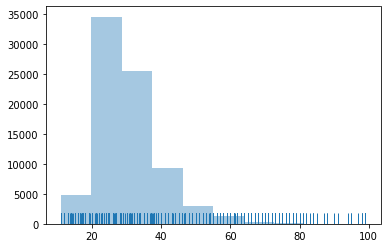

In [58]:
sns.distplot(ages, bins=10, rug=True, kde=False)

In [201]:
#wyznacz srednie zarobki w kraju jezeli kraj ma wiecej niz 1000 respondentow. top 10

country_sal = spark.sql(f"SELECT Country, mean(ConvertedComp) AS avg \
                          FROM {table_name} \
                          WHERE Country IS NOT NULL AND ConvertedComp IS NOT NULL \
                          GROUP BY Country HAVING Count(*)>1000 \
                          ORDER BY avg").toPandas()



In [71]:
country_sal

,Country,avg
0,India,28057.6649
1,Russian Federation,31124.3834
2,Brazil,32623.5700
3,Poland,38860.4413
4,France,81214.7797
5,Spain,88724.3573
6,Netherlands,100845.0726
7,Germany,109256.8841
8,Canada,134018.5649
9,United Kingdom,166182.4995


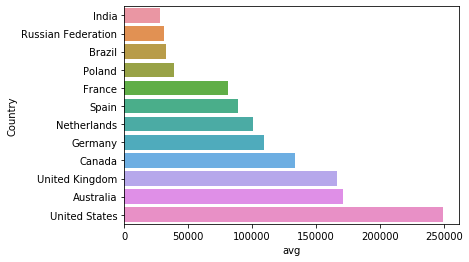

In [77]:
sns.barplot(y="Country", x="avg", data=country_sal)

In [202]:
# wykres pokazujacy rozrzut pensji w krajach ktore maja ponad 1000 repondentow

countryCont_data = spark.sql(f"SELECT Country, CAST(ConvertedComp AS INT) \
                          FROM {table_name} \
                          WHERE Country IS NOT NULL AND ConvertedComp IS NOT NULL \
                          AND Country IN \
                              (SELECT Country FROM {table_name} \
                               GROUP BY Country\
                               HAVING COUNT(*)>1000)\
                          ").toPandas()

countryCont_data

,Country,ConvertedComp
0,United States,61000
1,Canada,366420
2,India,13293
3,United States,90000
4,Germany,57060
...,...,...
40026,United States,2000000
40027,United States,180000
40028,United States,2000000
40029,United States,130000


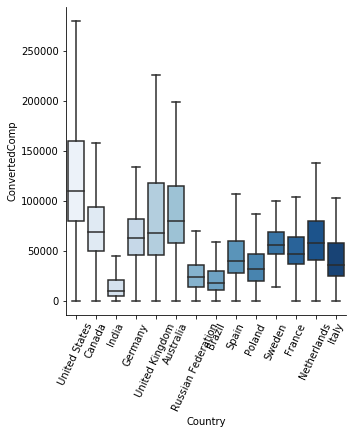

In [203]:
sns.catplot(x="Country", y="ConvertedComp", kind="box", data=countryCont_data, palette='Blues', showfliers=False) \
            .set_xticklabels (rotation=65)

In [204]:
# wyzncz 10 najbardziej popularnych jezykow programoania wsrod Datascientistów
all_lang = spark.sql(f"select LanguageWorkedWith from \
           {table_name}\
           where DevType like '%Data scientist%' AND LanguageWorkedWith is not null").toPandas()
 
all_lang

,LanguageWorkedWith
0,Java;R;SQL
1,C#;Go;JavaScript;Python;R;SQL
2,Bash/Shell/PowerShell;HTML/CSS;Java;Python;R;SQL
3,C++;Python;R
4,Bash/Shell/PowerShell;C++;Go;HTML/CSS;Java;Jav...
...,...
6388,C#;Python;SQL
6389,HTML/CSS;JavaScript;Python;Swift
6390,Java;Python;SQL;TypeScript
6391,HTML/CSS;JavaScript;Python


In [205]:
split = all_lang['LanguageWorkedWith'].str.split(';')
split

0                                          [Java, R, SQL]
1                    [C#, Go, JavaScript, Python, R, SQL]
2       [Bash/Shell/PowerShell, HTML/CSS, Java, Python...
3                                        [C++, Python, R]
4       [Bash/Shell/PowerShell, C++, Go, HTML/CSS, Jav...
                              ...                        
6388                                    [C#, Python, SQL]
6389                [HTML/CSS, JavaScript, Python, Swift]
6390                      [Java, Python, SQL, TypeScript]
6391                       [HTML/CSS, JavaScript, Python]
6392    [Bash/Shell/PowerShell, C, C++, HTML/CSS, Java...
Name: LanguageWorkedWith, Length: 6393, dtype: object

In [206]:
from itertools import chain
lang_list=chain.from_iterable(split)
lang_list

In [207]:
lang_pd = pd.DataFrame({"lang" : lang_list})
lang_pd

,lang
0,Java
1,R
2,SQL
3,C#
4,Go
...,...
35173,HTML/CSS
35174,Java
35175,JavaScript
35176,Python


In [208]:
lang_summary = lang_pd.groupby("lang").size().to_frame('cnt')
lang_summary.sort_values("cnt", ascending=False, inplace=True)
lang_summary

,cnt
lang,
Python,5125
SQL,3775
JavaScript,3319
HTML/CSS,3258
Bash/Shell/PowerShell,2874
Java,2453
C++,2066
R,1975
C,1674


In [209]:
def prep_lang(df, col_name="LanguageWorkedWith", out="lang"):
    lang_list=chain.from_iterable(df[col_name].str.split(';'))
    lang_pd = pd.DataFrame({"lang" : lang_list})
    lang_summary = lang_pd.groupby("lang").size().to_frame('cnt')
    lang_summary.sort_values('cnt', ascending=False, inplace=True)
    return lang_summary 

In [210]:
all_lang = spark.sql(f"select LanguageWorkedWith from \
           {table_name}\
           where DevType like '%Data scientist%' AND LanguageWorkedWith is not null").toPandas()

In [211]:
summary = prep_lang(all_lang)
summary

,cnt
lang,
Python,5125
SQL,3775
JavaScript,3319
HTML/CSS,3258
Bash/Shell/PowerShell,2874
Java,2453
C++,2066
R,1975
C,1674


In [212]:
all_lang = spark.sql(f"select LanguageDesireNextYear from \
           {table_name}\
           where DevType like '%Data scientist%' AND LanguageDesireNextYear is not null").toPandas()
summary = prep_lang(all_lang, col_name="LanguageDesireNextYear")
summary

,cnt
lang,
Python,4824
SQL,2737
JavaScript,2403
Bash/Shell/PowerShell,1972
HTML/CSS,1898
R,1818
C++,1711
Java,1426
Go,1226


In [174]:
# HEATMAPA STACK OVERFLOW

visit_freq_options = spark.sql(f"SELECT DISTINCT SOVisitFreq FROM {table_name}").toPandas()
visit_freq_options

,SOVisitFreq
0,A few times per week
1,A few times per month or weekly
2,None
3,Daily or almost daily
4,I have never visited Stack Overflow (before to...
5,Less than once per month or monthly
6,Multiple times per day


In [190]:
so_freq = spark.sql(f"SELECT t1.Country, SOVisitFreq, count(*)/first(t2.total_count) * 100 as pct\
            from {table_name} t1\
            JOIN (select Country, Count(*) as total_count \
                  from {table_name} \
                  group by Country \
                  having Count(*) > 1000 ) t2\
            ON t1.Country = t2.Country \
            where t1.Country is not null and\
            t1.Country in (select country from {table_name} group by country\
            having count(*) >1000)\
            group by t1.Country, SOVisitFreq").toPandas()

In [198]:
so_freq['SOVisitFreq'] = pd.Categorical(so_freq['SOVisitFreq'], ["I have never visited Stack Overflow (before today)",
                                                                 "Less than once per month or monthly",
                                                                 "A few times per month or weekly",
                                                                 "A few times per week",
                                                                 "Daily or almost daily",
                                                                 "Multiple times per day"])

heatmap_data = pd.pivot_table(so_freq, values="pct", index=["Country"], columns="SOVisitFreq")

In [191]:
so_freq

,Country,SOVisitFreq,pct
0,United Kingdom,A few times per month or weekly,13.038173
1,Spain,Daily or almost daily,33.104738
2,Poland,Less than once per month or monthly,2.809573
3,Spain,A few times per month or weekly,10.162095
4,Netherlands,Daily or almost daily,29.049676
...,...,...,...
92,Poland,Daily or almost daily,30.749220
93,France,I have never visited Stack Overflow (before to...,0.209118
94,Sweden,Daily or almost daily,32.731554
95,United Kingdom,None,0.313753


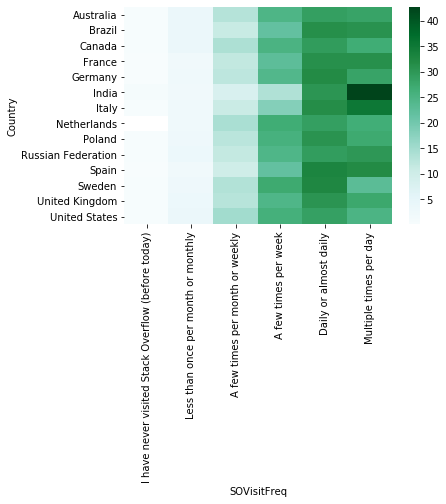

In [199]:
sns.heatmap(heatmap_data, cmap="BuGn")